# Zalando case study

In this notebook we perform some preprocessing to the raw dataset in order to set it ready for a further, more advanced analysis and forecasting. After that we will analize top customers by activity and predict their expected sales for December 2017 using the ARIMA forecasting model. Finally we will extend the ARIMA model to the whole dataset.

## Data Preprocessing

### Importing libraries and dataset

In [1]:
# Import pandas
import pandas as pd

In [2]:
# Load dataset into dataframe
df_sales = pd.read_csv('Sales.csv')
df_sales.head()

,product,date,customer,country,sales
0,85123A,2016-12-01,17850,United Kingdom,15.30
1,71053,2016-12-01,17850,United Kingdom,20.34
2,84406B,2016-12-01,17850,United Kingdom,22.00
3,84029G,2016-12-01,17850,United Kingdom,20.34
4,84029E,2016-12-01,17850,United Kingdom,20.34


In [3]:
# Visualize data statistics
df_sales.describe()

,customer,sales
count,406829.000000,406829.000000
mean,15287.690570,20.401854
std,1713.600303,427.591718
min,12346.000000,-168469.600000
25%,13953.000000,4.200000
50%,15152.000000,11.100000
75%,16791.000000,19.500000
max,18287.000000,168469.600000


### Analizing and Preprocessing the data

In [4]:
# Check 'date' datatype
type(df_sales.date[0])

str

In [5]:
# Cast 'date' to datetime
df_sales.date = pd.to_datetime(df_sales.date, format='%Y-%m-%d')
type(df_sales.date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [6]:
# Eliminate duplicate values
df_sales = df_sales.drop_duplicates(subset=None, keep='first', inplace=False)

In [7]:
# Apply some filtering to obtain a one-year dataset
start_date = "2016-12-01"
end_date = "2017-11-30"

after_start_date = df_sales["date"] >= start_date
before_end_date = df_sales["date"] <= end_date
between_two_dates = after_start_date & before_end_date

df_sales = df_sales.loc[between_two_dates]

In [8]:
# Visualize data statistics
df_sales.describe()

,customer,sales
count,382785.000000,382785.000000
mean,15278.340314,20.598134
std,1712.037074,213.569099
min,12346.000000,-77183.600000
25%,13931.000000,4.250000
50%,15147.000000,11.700000
75%,16778.000000,19.800000
max,18287.000000,77183.600000


### Product Analysis

In [9]:
# Visualize product distribution
products = 100 * df_sales['product'].value_counts() / df_sales['product'].value_counts().sum()
products.head(10)

85123A    0.519090
22423     0.479904
85099B    0.420340
47566     0.361822
84879     0.355291
20725     0.342490
22720     0.309835
POST      0.297817
23203     0.277963
22383     0.276918
Name: product, dtype: float64

In [10]:
# Products are uniformly distributed. 
# Drop 'product' information from the dataset since it won't add any significant contribution to the analysis
df_model_data = df_sales.drop(columns=['product'])
df_model_data

,date,customer,country,sales
0,2016-12-01,17850,United Kingdom,15.30
1,2016-12-01,17850,United Kingdom,20.34
2,2016-12-01,17850,United Kingdom,22.00
3,2016-12-01,17850,United Kingdom,20.34
4,2016-12-01,17850,United Kingdom,20.34
...,...,...,...,...
389163,2017-11-30,15676,United Kingdom,-0.85
389164,2017-11-30,15676,United Kingdom,-3.29
389165,2017-11-30,16717,United Kingdom,-1.25
389166,2017-11-30,16717,United Kingdom,-7.95


### Country Analysis

In [11]:
# Visualize country distribution
countries = df_model_data.country.value_counts().to_frame().reset_index().rename(columns = {'index': 'country',
                                                                                           'country': 'count'})
countries.head(10)

,country,count
0,United Kingdom,339649
1,Germany,9122
2,France,8106
3,EIRE,7095
4,Spain,2457
5,Netherlands,2278
6,Belgium,1971
7,Switzerland,1877
8,Portugal,1352
9,Australia,1251


In [12]:
# Visualize the percentage of sales for each country
c = 100 * df_sales['country'].value_counts() / df_sales['country'].value_counts().sum()
c.head(10)

United Kingdom    88.731011
Germany            2.383061
France             2.117638
EIRE               1.853521
Spain              0.641875
Netherlands        0.595112
Belgium            0.514910
Switzerland        0.490354
Portugal           0.353201
Australia          0.326815
Name: country, dtype: float64

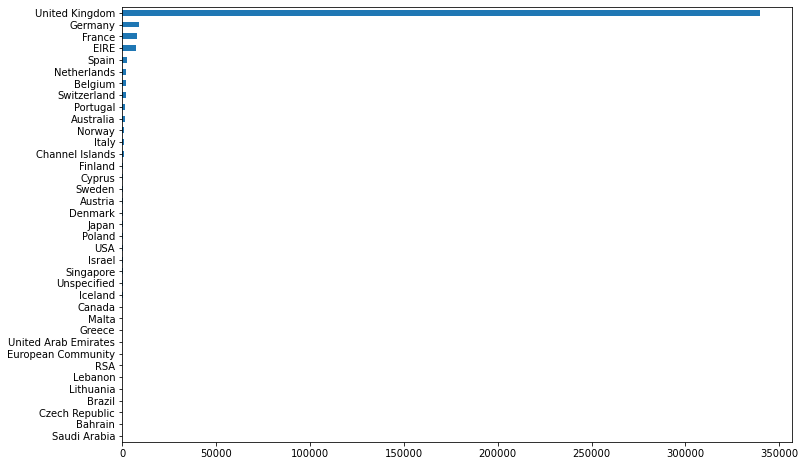

In [13]:
# Plotting the country distribution
df_model_data.country.value_counts().plot(kind='barh', figsize=(12,8)).invert_yaxis()

In [14]:
# Country distribution is highly skewed
# Drop 'country' information from the dataset since it won't add any significant contribution to the analysis
df_model_data.drop(columns = ['country'], inplace=True)
df_model_data

,date,customer,sales
0,2016-12-01,17850,15.30
1,2016-12-01,17850,20.34
2,2016-12-01,17850,22.00
3,2016-12-01,17850,20.34
4,2016-12-01,17850,20.34
...,...,...,...
389163,2017-11-30,15676,-0.85
389164,2017-11-30,15676,-3.29
389165,2017-11-30,16717,-1.25
389166,2017-11-30,16717,-7.95


### Aggregating the dataset

In [15]:
# Keep only year & month information
# Drop the daily detail
df_model_data['date'] = df_model_data['date'].dt.strftime('%Y-%m')

In [16]:
# Aggregating 'sales' information and resetting the index
df_model_data = df_model_data.groupby([df_model_data['date'], 'customer']).sum()

df_model_data = df_model_data.reset_index()
df_model_data

,date,customer,sales
0,2016-12,12347,7.117900e+02
1,2016-12,12348,8.928000e+02
2,2016-12,12370,1.864270e+03
3,2016-12,12377,1.001520e+03
4,2016-12,12383,6.007200e+02
...,...,...,...
12984,2017-11,18263,3.996800e+02
12985,2017-11,18270,1.712000e+02
12986,2017-11,18274,-1.598721e-14
12987,2017-11,18276,-6.250000e+00


The dataset is ready for further advanced analysis.

## Advanced Analysis and Forecasting

### Top customer Analysis

In [31]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import itertools
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [25]:
# Create a reduced dataset composed by the top customers by activity
top_users = list(df_model_data['customer'].value_counts().head(48).index)

top_users_df = df_model_data[df_model_data['customer'].isin(top_users)]
top_users_df

,date,customer,sales
46,2016-12,12709,1315.69
48,2016-12,12720,639.13
56,2016-12,12748,3984.42
72,2016-12,12841,505.99
91,2016-12,12971,396.69
...,...,...,...
12840,2017-11,17735,562.71
12875,2017-11,17841,6885.12
12898,2017-11,17949,720.00
12938,2017-11,18109,785.94


In [26]:
# Visualize the sales activity for the Top customer dataset
fig = px.line(df_model_data[df_model_data['customer'].isin(top_users)], x="date", y="sales", color='customer')
fig.show()

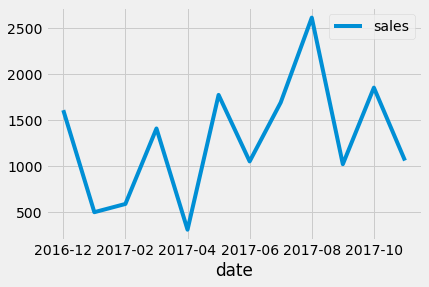

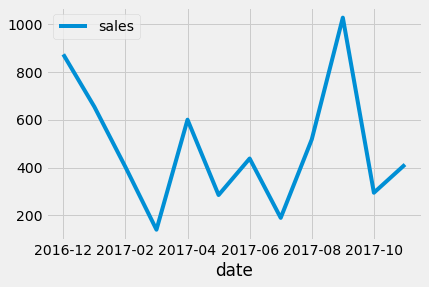

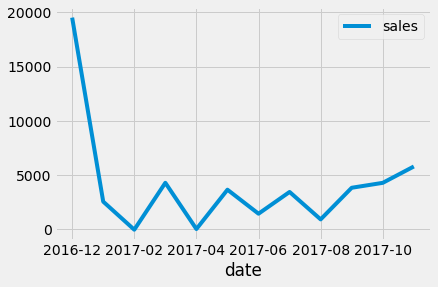

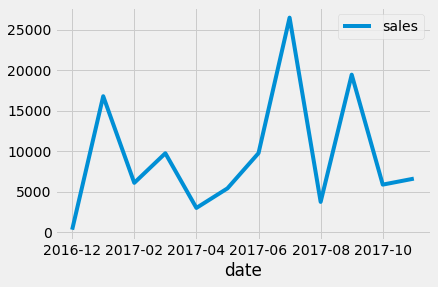

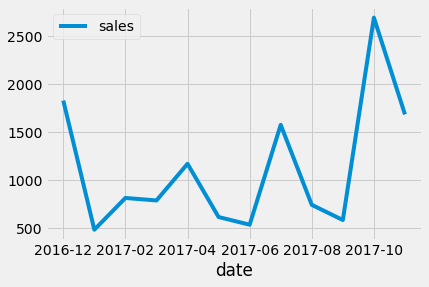

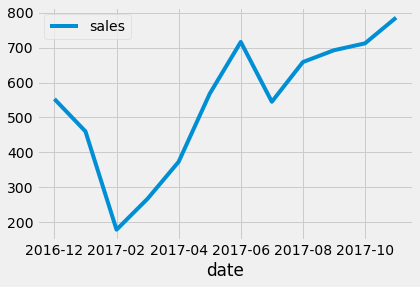

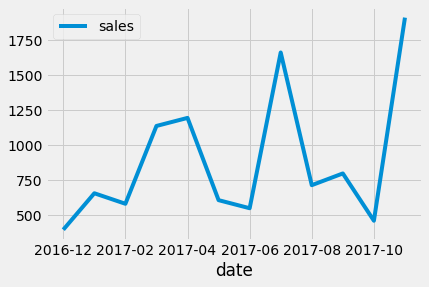

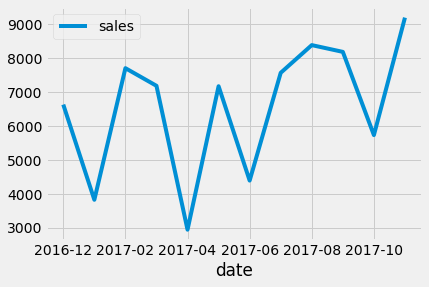

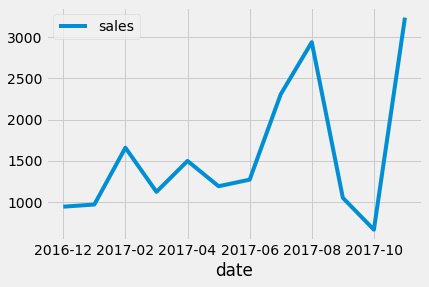

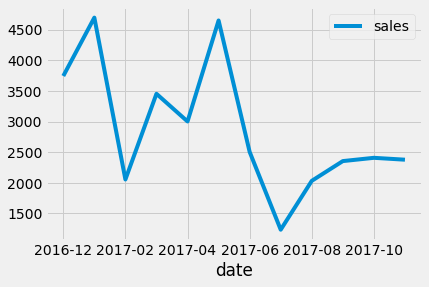

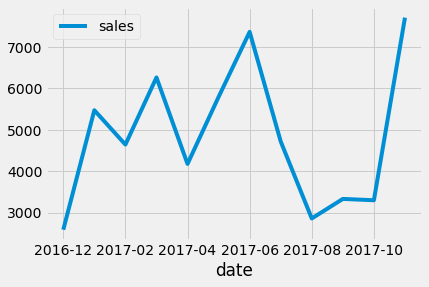

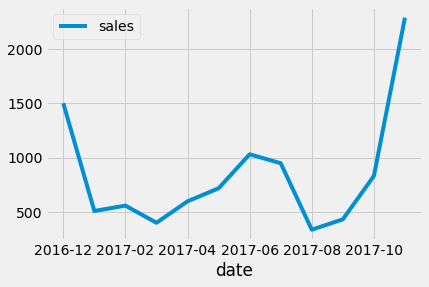

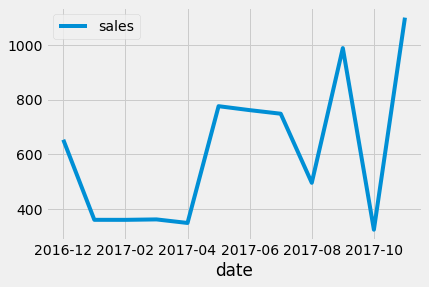

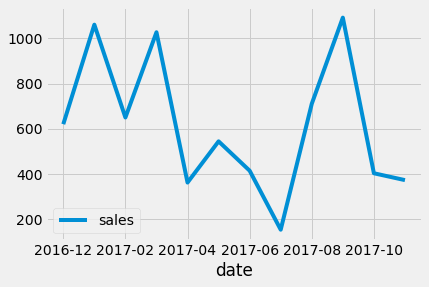

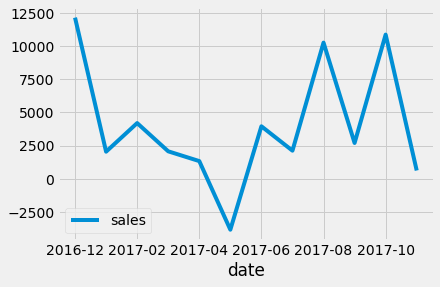

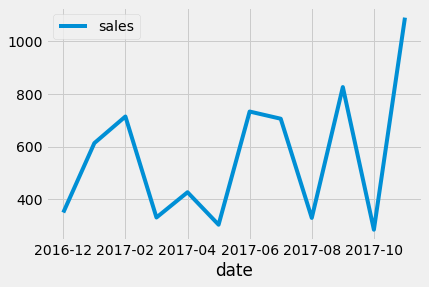

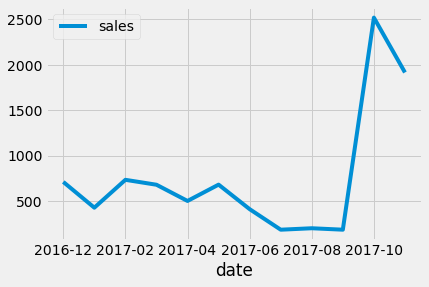

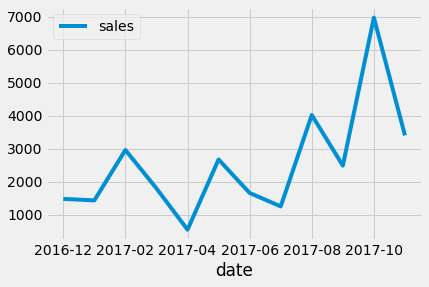

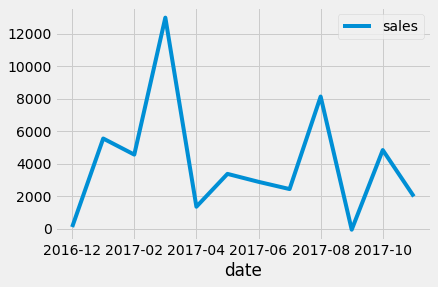

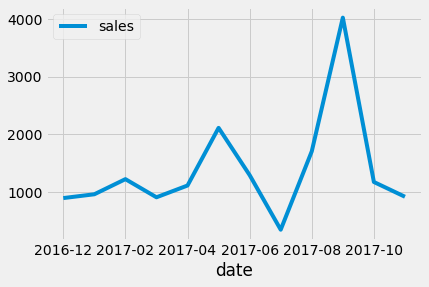

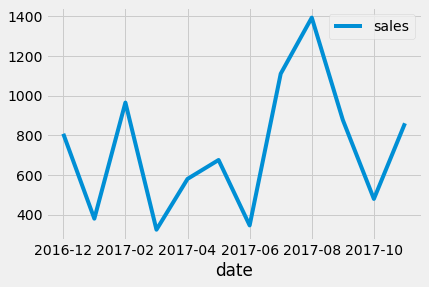

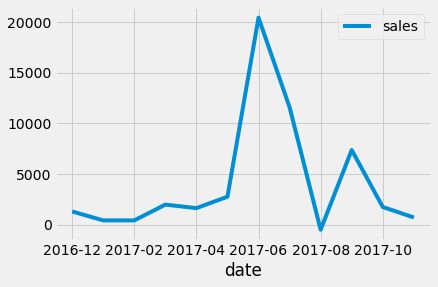

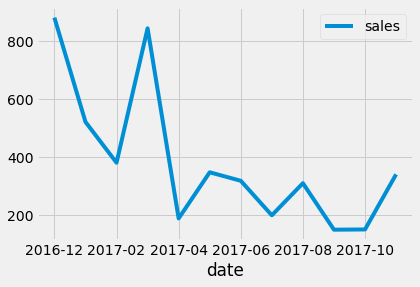

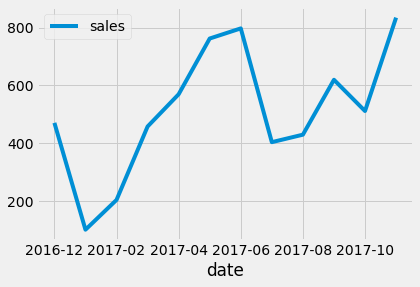

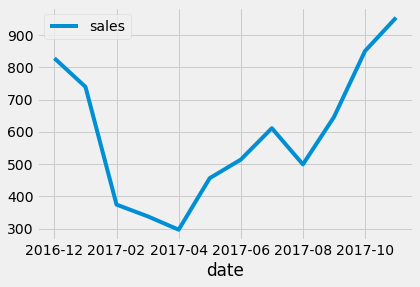

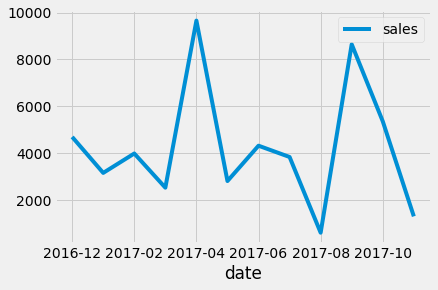

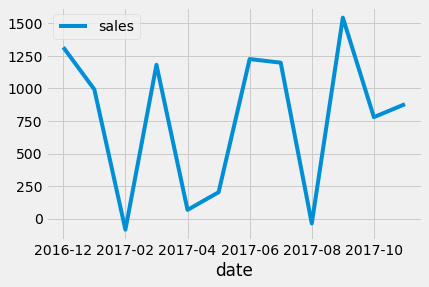

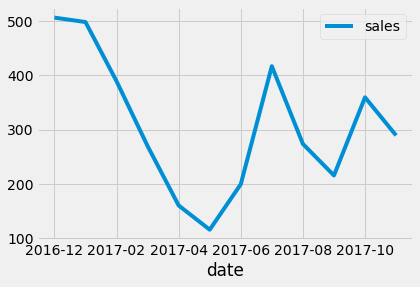

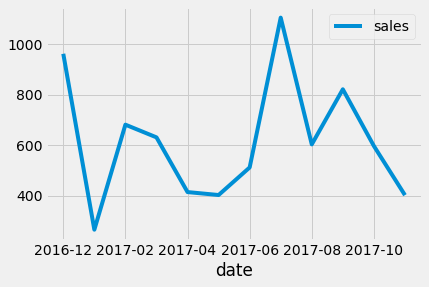

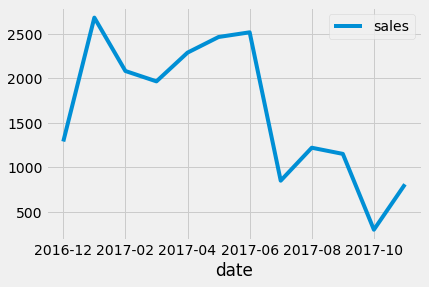

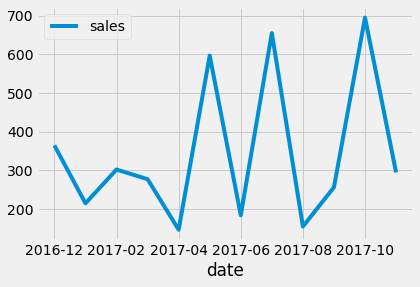

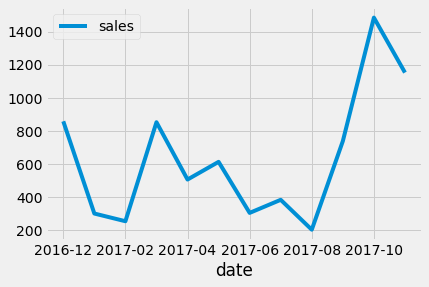

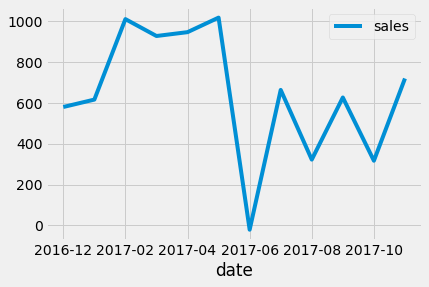

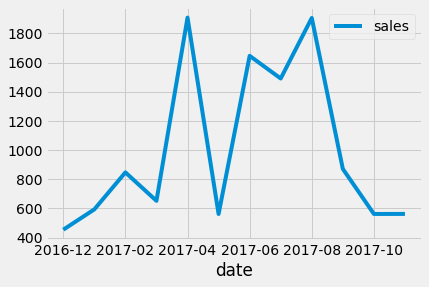

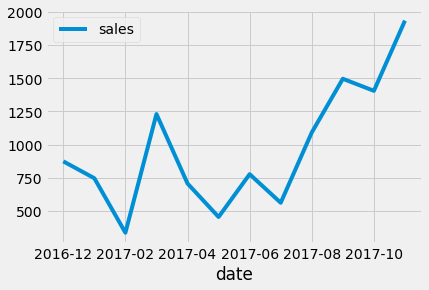

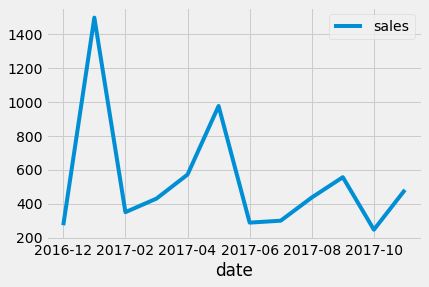

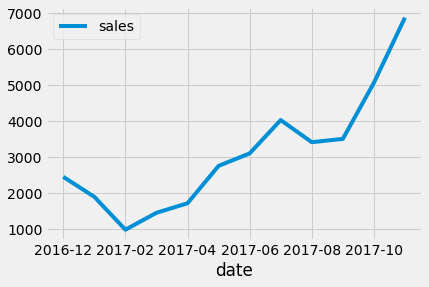

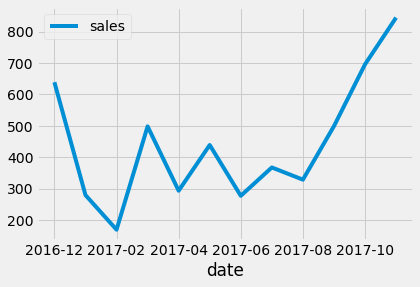

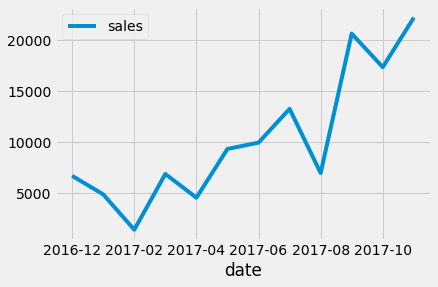

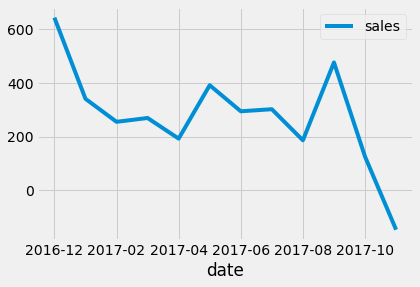

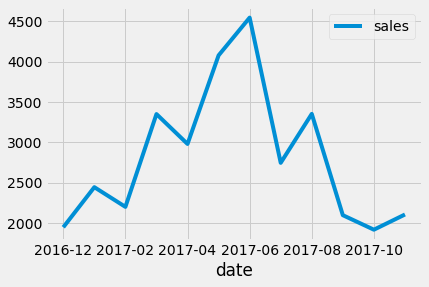

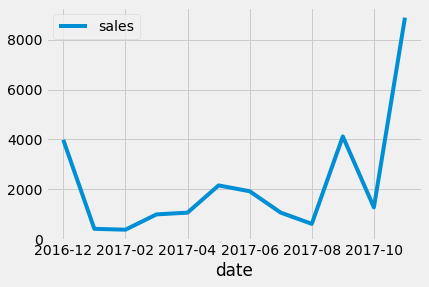

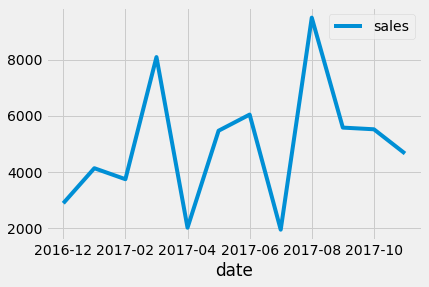

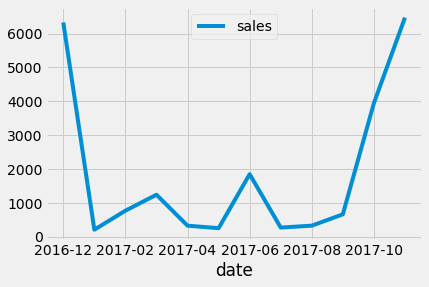

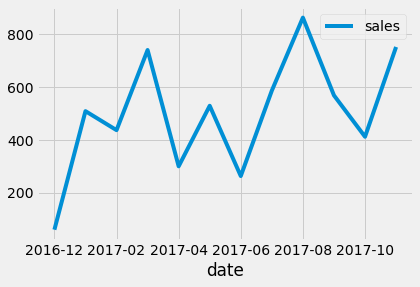

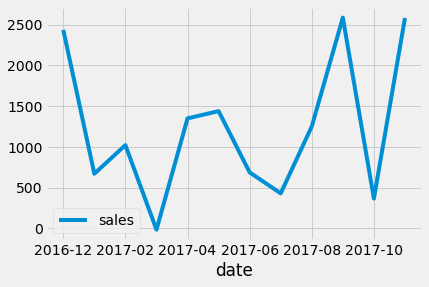

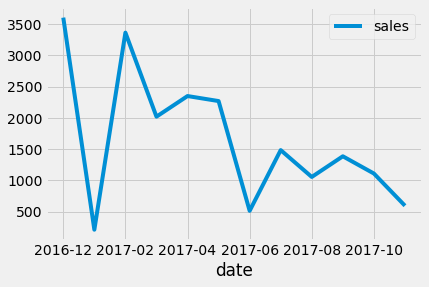

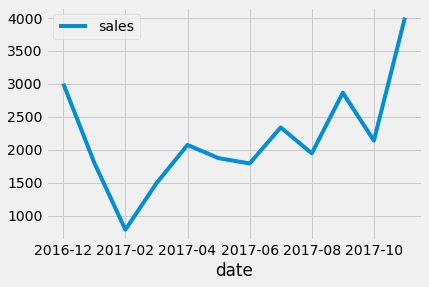

In [28]:
# Visualize the sales activity for each of the Top customer separately
for user in top_users:
    top_users_df[top_users_df.customer==user].drop(columns = 'customer').set_index('date').plot()

### Single Customer Analysis

In [30]:
# Analyze one of the top customers
df = top_users_df[top_users_df.customer==12709].drop(columns = 'customer').set_index('date')
df

,sales
date,
2016-12,1315.69
2017-01,992.44
2017-02,-83.98
2017-03,1181.20
2017-04,68.00
2017-05,203.45
2017-06,1225.26
2017-07,1197.66
2017-08,-36.05


<AxesSubplot:xlabel='date'>

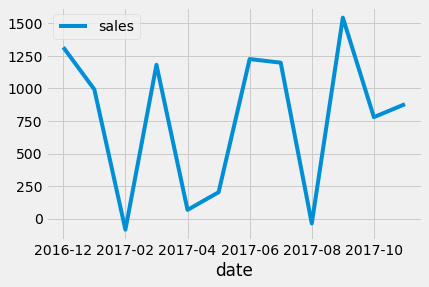

In [35]:
# Visualize its sales activity in time
top_users_df[top_users_df.customer==12709].drop(columns = 'customer').set_index('date').plot()

We will perform now the Augmented Dickey-Fuller test on the previously created dataset for custumer 12709 in order to check for stationarity / non-stationarity in the series. 

A data series is non-stationary if it presents trends or seasonal patterns. If not corrected, these patterns could negatively affect the regression model.

In [34]:
# Perform the ADF test

result = adfuller(df.sales, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -4.609891554571171
n_lags: 0.00012385431963299172
p-value: 0.00012385431963299172
Critial Values:
   1%, -4.223238279489106
Critial Values:
   5%, -3.189368925619835
Critial Values:
   10%, -2.729839421487603


The p-value obtained by the ADF test is smaller than the sinificance level of 0.05 and the ADF statistic is higher than any of the critical values. This means that the serie is stationary.

In [40]:
# ARIMA forecasting model

from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.sales, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                   12
Model:                     ARMA(1, 0)   Log Likelihood                 -92.033
Method:                       css-mle   S.D. of innovations            515.234
Date:                Tue, 12 Oct 2021   AIC                            190.067
Time:                        21:26:16   BIC                            191.521
Sample:                    12-01-2016   HQIC                           189.528
                         - 11-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         757.0397    111.961      6.762      0.000     537.601     976.479
ar.L1.sales    -0.3629      0.266     -1.365      0.172      -0.884       0.158
                                    Roots       

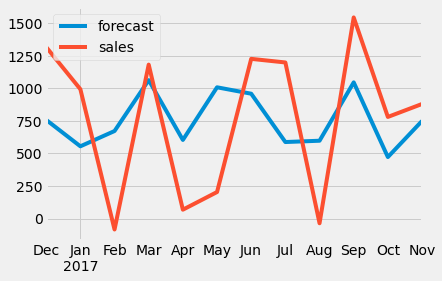

In [41]:
# Visualize the forecasted sales data
model_fit.plot_predict()
plt.show()

In [42]:
# Print the predicted value for December 2017
model_fit.predict(1,df.shape[0]).tail(1).values[0]

712.7456313095944

### Arima predictions

In [ ]:
# Create two empty set to append the predictions
user_id = []
prediction = []

In [ ]:
# Iteratevely perform ARIMA forcasts

for user in df_model_data.customer.values:
  
  df = df_model_data[df_model_data.customer==user].drop(columns = 'customer').set_index('date')
  
  try:
    model = ARIMA(df.sales, order=(1,0,0))
    model_fit = model.fit(disp=0)
    user_id.append(user)
    prediction.append(abs(model_fit.predict(1,df.shape[0]).tail(1).values[0])) 
  except:
    print(user, 'has not sufficient values to predict')


12347 has not suffieint values to predict
12348 has not suffieint values to predict
12370 has not suffieint values to predict
12377 has not suffieint values to predict
12383 has not suffieint values to predict
12386 has not suffieint values to predict
12395 has not suffieint values to predict
12417 has not suffieint values to predict
12423 has not suffieint values to predict
12427 has not suffieint values to predict
12429 has not suffieint values to predict
12431 has not suffieint values to predict
12433 has not suffieint values to predict
12434 has not suffieint values to predict
12441 has not suffieint values to predict
12471 has not suffieint values to predict
12472 has not suffieint values to predict
12474 has not suffieint values to predict
12476 has not suffieint values to predict
12481 has not suffieint values to predict
12494 has not suffieint values to predict
12515 has not suffieint values to predict
12540 has not suffieint values to predict
12551 has not suffieint values to 

In [ ]:
# Create dataframe with predictions results
prediction = pd.DataFrame({'user_id': user_id,
              'prediction': prediction})

prediction = prediction.groupby('user_id').mean()

prediction.head(10)

In [ ]:
# Generate .csv document with predictions
prediction.to_csv('prediction_dec.csv')